In [1]:
from emulator_utils.pre_process import log_standard, minmax, unscale
from emulator_utils.read_data import readpowerspec
from emulator_utils.split import random_holdout
from emulator_utils.surrogates import simple_mlp, train_mlp, save_mlp, load_mlp

In [2]:
import matplotlib.pylab as plt
import numpy as np
from glob import glob

### Reading spectra

In [3]:
k, _, _, _ = readpowerspec('../test/data/powerspec_LJ/m000p.pk.499')
fnames = glob('../test/data/powerspec_LJ/*')
pk_all = np.array([readpowerspec(f)[1] for f in fnames])

### Using a pre-processing pipeline

In [4]:
scaled, scaler = log_standard(pk_all)

### Using mock data here, will be rescaled as well

In [5]:
params = np.arange(scaled.shape[0]).reshape(-1, 1)
scaled_y, scaler_y = minmax(params)

In [6]:
pk_train, pk_test, param_train, param_test = random_holdout(scaled, params, split_fraction = 0.2)

Text(0, 0.5, 'Pk')

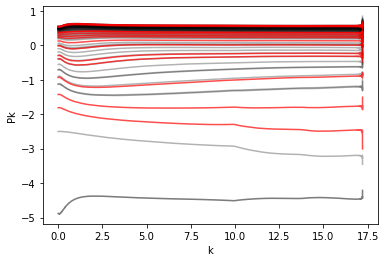

In [7]:
plt.figure(1)
plt.plot(k, pk_train.T, 'k', alpha=0.3)
plt.plot(k, pk_test.T, 'r', alpha=0.7)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('k')
plt.ylabel('Pk')

### Sample neural network 

### Fixing the network architecture (hidden_dims is flexible)

In [8]:
mlp = simple_mlp(input_shape=param_train.shape[1], 
                 output_shape=pk_train.shape[1], 
                 hidden_dims=[16, 128, 1024, 4096])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 128)               2176      
                                                                 
 dense_2 (Dense)             (None, 1024)              132096    
                                                                 
 dense_3 (Dense)             (None, 4096)              4198400   
                                                                 
 dense_4 (Dense)             (None, 9311)              38147167  
                                                                 
Total params: 42,479,871
Trainable params: 42,479,871
Non-trainable params: 0
_________________________________________________________________
None


### Set-up hyper-parameters

In [9]:
learning_rate = 0.01
decay_rate = 0.01
batch_size = 10
num_epochs = 10

In [10]:
mlp, train_history = train_mlp(mlp, 
                    param_train, pk_train, param_test, pk_test, 
                    learning_rate, decay_rate, num_epochs, batch_size)

Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 17075.3945 - binary_crossentropy: 5.9584 - val_loss: 8.1008 - val_binary_crossentropy: 5.9321
Epoch 2/10
6/6 [==============================] - 0s 22ms/step - loss: 56.1670 - binary_crossentropy: 6.6955 - val_loss: 85.5939 - val_binary_crossentropy: 6.9735
Epoch 3/10
6/6 [==============================] - 0s 22ms/step - loss: 16.0805 - binary_crossentropy: 6.0282 - val_loss: 0.8384 - val_binary_crossentropy: -0.6375
Epoch 4/10
6/6 [==============================] - 0s 22ms/step - loss: 1.9656 - binary_crossentropy: 1.8757 - val_loss: 1.3451 - val_binary_crossentropy: 2.5558
Epoch 5/10
6/6 [==============================] - 0s 24ms/step - loss: 1.2495 - binary_crossentropy: 1.0850 - val_loss: 0.8012 - val_binary_crossentropy: -0.4575
Epoch 6/10
6/6 [==============================] - 0s 23ms/step - loss: 1.1069 - binary_crossentropy: 0.9125 - val_loss: 0.8413 - val_binary_crossentropy: -0.7734
Epoch 7/10
6/6 [========

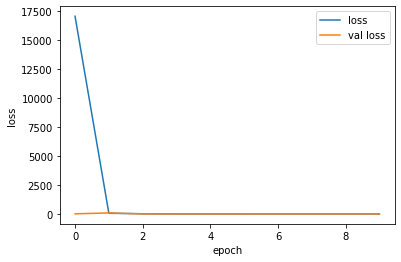

In [11]:
plt.figure(2111)
plt.plot(train_history.history['loss'], label = 'loss')
plt.plot(train_history.history['val_loss'], label = 'val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [12]:
save_mlp(mlp, '../test/model/trained_mlp')
mlp = load_mlp('../test/model/trained_mlp')

2022-04-19 14:36:42.174904: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../test/model/trained_mlp/assets
Model saved at../test/model/trained_mlp


In [13]:
mlp_pred = mlp.predict(param_test)
pk_pred = unscale(mlp_pred, scaler)

Text(0, 0.5, 'Pk')

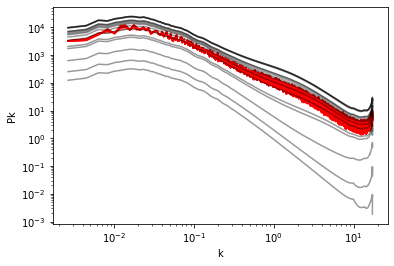

In [14]:
plt.figure(1)
plt.plot(k, pk_pred.T, 'r', alpha=0.5)
plt.plot(k, unscale(pk_test, scaler).T, 'k', alpha=0.4)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('Pk')

## explainers 

In [15]:
from emulator_utils.explainers import shap_estimate
from emulator_utils.explainers import plot_shap_summary_single, plot_shap_summary_multiple
from emulator_utils.explainers import plot_shap_force_single, plot_shap_force_multiple
from emulator_utils.explainers import global_explainer

In [16]:
explainer, shap_values, expected_values = shap_estimate(mlp, param_train, param_test, ['redshift'], ['pk'])

  0%|          | 0/16 [00:00<?, ?it/s]

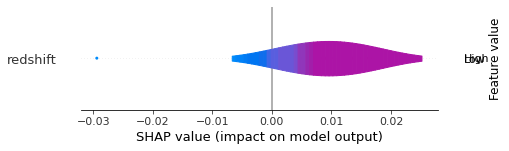

In [17]:
output_indx = 1002  ## k-bin value
plot_shap_summary_single(shap_values[output_indx], param_test, ['redshift'], plot_type='violin')

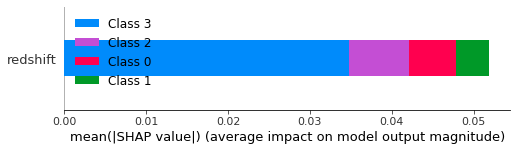

In [40]:
plot_shap_summary_multiple(shap_values[:2000:500], param_test, ['redshift'], plot_type='bar')

In [24]:

import alibi
from alibi.explainers import KernelShap
from alibi.explainers import IntegratedGradients
from alibi.explainers import ALE
from alibi.explainers import plot_ale
import matplotlib.pylab as plt

import shap

In [42]:
k[:2000:500]

array([2.617542e-03, 9.267230e-01, 1.850670e+00, 2.774618e+00])

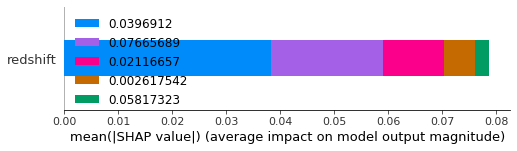

In [54]:

shap.summary_plot(shap_values[:50:10], param_test, ['redshift'], plot_type='bar', sort=False, color_bar=False, class_names=k[:50:10])

In [19]:
plot_shap_force_multiple(expected_values, shap_values, ['redshift'], ['pk'], 0)

In [20]:
plot_shap_force_single(expected_values, shap_values, ['redshift'], ['pk'], 0, 11)

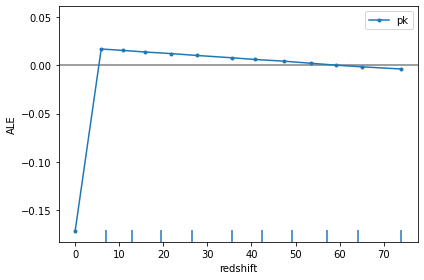

In [22]:
global_explainer(mlp, param_train, param_test, ['redshift'], ['pk']);